In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

#Load the data
df = pd.read_excel('pharma_forecasting_dummy_custom_500.xlsx')

In [17]:
df.head()

,Year,Country,Product Name,Dosage Form,Manufacturer,Price (USD),Units,Market / Channel,Sales (USD)
0,2025,India,DrugD,Syrup,Novartis,474.74,156,Retail,74059.44
1,2025,India,DrugB,Capsule,Roche,87.22,86,Retail,7500.92
2,2024,Germany,DrugB,IV Infusion,Sanofi,489.55,82,Hospital,40143.10
3,2025,Brazil,DrugC,Tablet,Sanofi,416.42,113,Hospital,47055.46
4,2024,Germany,DrugD,Capsule,Pfizer,43.98,166,Hospital,7300.68


In [5]:
#filter data

germany_drugc = df[(df['Country'] == 'Germany') & (df['Product Name'] == 'DrugC')].copy()

In [15]:
#Convert to datetime and set a index

germany_drugc['Date'] = pd.to_datetime(germany_drugc['Year'].astype(str) + '-01-01')
germany_drugc.set_index('Date', inplace = True)

In [19]:
quarterly_sales = germany_drugc['Sales (USD)'].resample('Q').sum()

In [21]:
print(quarterly_sales)

Date
2023-03-31    159864.99
2023-06-30         0.00
2023-09-30         0.00
2023-12-31         0.00
2024-03-31    458338.85
2024-06-30         0.00
2024-09-30         0.00
2024-12-31         0.00
2025-03-31    283723.09
Freq: QE-DEC, Name: Sales (USD), dtype: float64


In [23]:
#Ploting data in time series

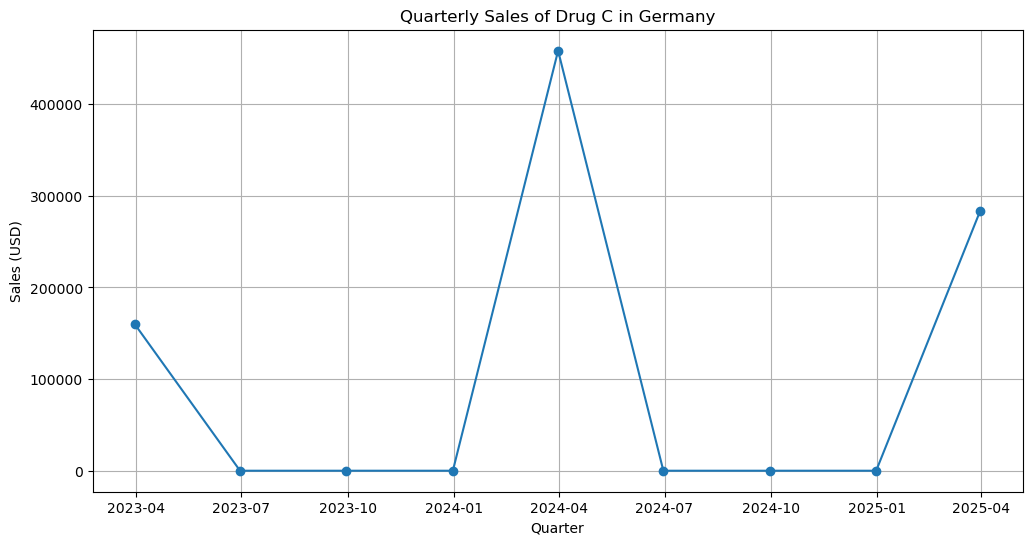

<Figure size 640x480 with 0 Axes>

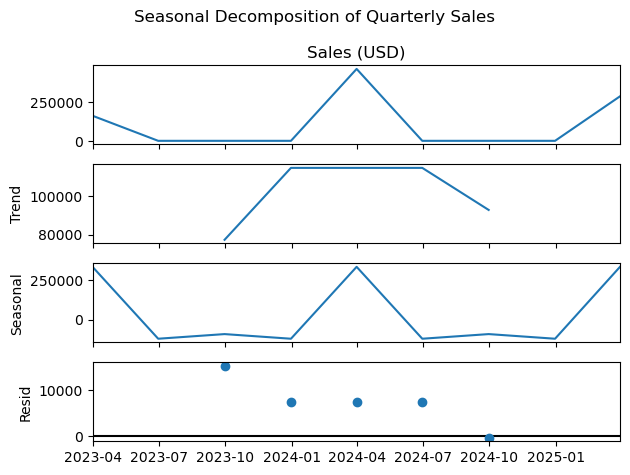

In [31]:
plt.figure(figsize = (12,6))
plt.plot(quarterly_sales, marker = 'o')
plt.title('Quarterly Sales of Drug C in Germany')
plt.xlabel('Quarter')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.show()

#Seasonal decomposition to understand patterns
decomposition = seasonal_decompose(quarterly_sales, model = 'additive', period = 4)

plt.figure(figure = (12,8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Quarterly Sales')
plt.tight_layout()
plt.show()

In [61]:
#Checking with adfuler model, about the stationarity of the model

from statsmodels.tsa.stattools import adfuller

def check_stationary(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('P value: ', result[1])
    print('Critical Values: ')
    for key, value in result[4].items():
        print(f' {key}: {value}')

    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

print("Stationarity Check")
check_stationary(quarterly_sales)

Stationarity Check
ADF Statistic: -3.161422112398691
P value:  0.022329160211726106
Critical Values: 
 1%: -5.354256481481482
 5%: -3.6462381481481483
 10%: -2.901197777777778
Series is stationary


After first difference
ADF Statistic: -2.34916863763093
P value:  0.1565998560593012
Critical Values: 
 1%: -6.045114
 5%: -3.9292800000000003
 10%: -2.98681
Series is not stationary


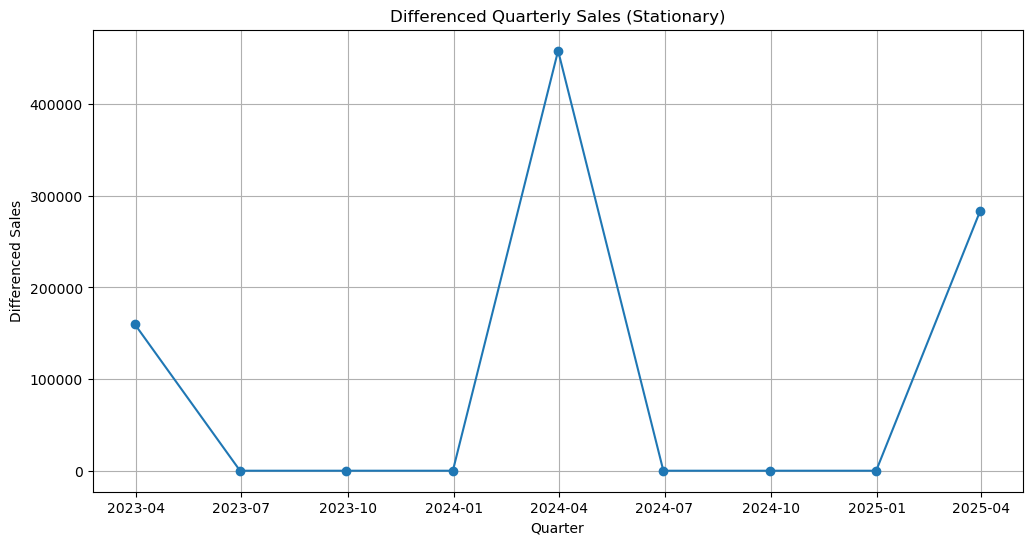

In [59]:
# Differnce the series to make it stationary

## It is better to use .differnce for making difference data
diff_sales = quarterly_sales.diff().dropna()

print('After first difference')
check_stationary(diff_sales)

#Plot the original series as the resulted series is not in stionary
plt.figure(figsize = (12,6))
plt.plot(quarterly_sales, marker = 'o')
plt.title('Differenced Quarterly Sales (Stationary)')
plt.xlabel('Quarter')
plt.ylabel('Differenced Sales')
plt.grid(True)
plt.show()

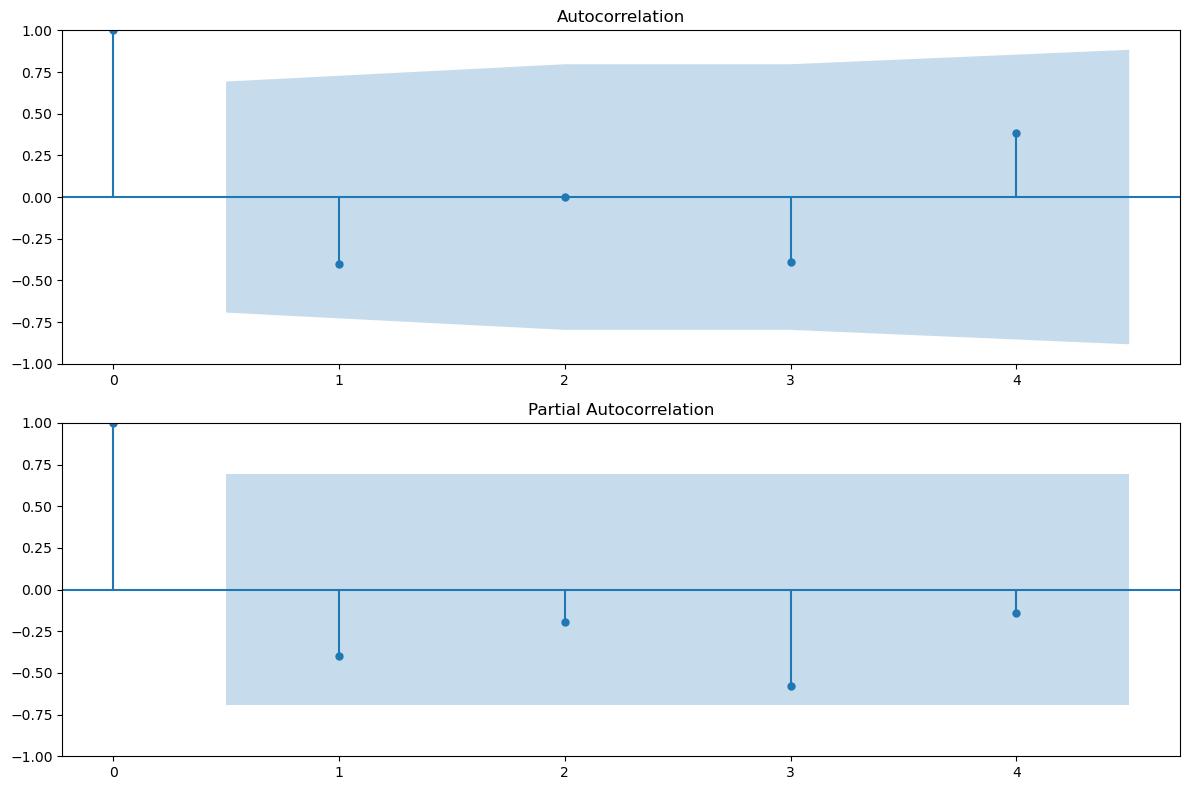

In [43]:
#Creating plot for acf and pacf regarding the model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,8))
plot_acf(diff_sales, ax = ax1, lags = 4)
plot_pacf(diff_sales, ax = ax2, lags = 4)
plt.tight_layout()
plt.show()

In [45]:
#Based on our analysis, let's use a simple SARIMA Model
#SARIMA(p,d,q)(P,D,Q,s) where s = 4 for the quarterly data

model = SARIMAX(quarterly_sales,
               order=(1,1,1),
               seasonal_order=(1,1,1,4))

result = model.fit()
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       Sales (USD)   No. Observations:                    9
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                 -51.986
Date:                           Wed, 24 Sep 2025   AIC                            113.973
Time:                                   16:22:49   BIC                            110.904
Sample:                               03-31-2023   HQIC                           107.239
                                    - 03-31-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0585   2357.679  -2.48e-05      1.000   -4621.025    4620.908
ma.L1         -0.7555    1.2e+04  -6.29e-05

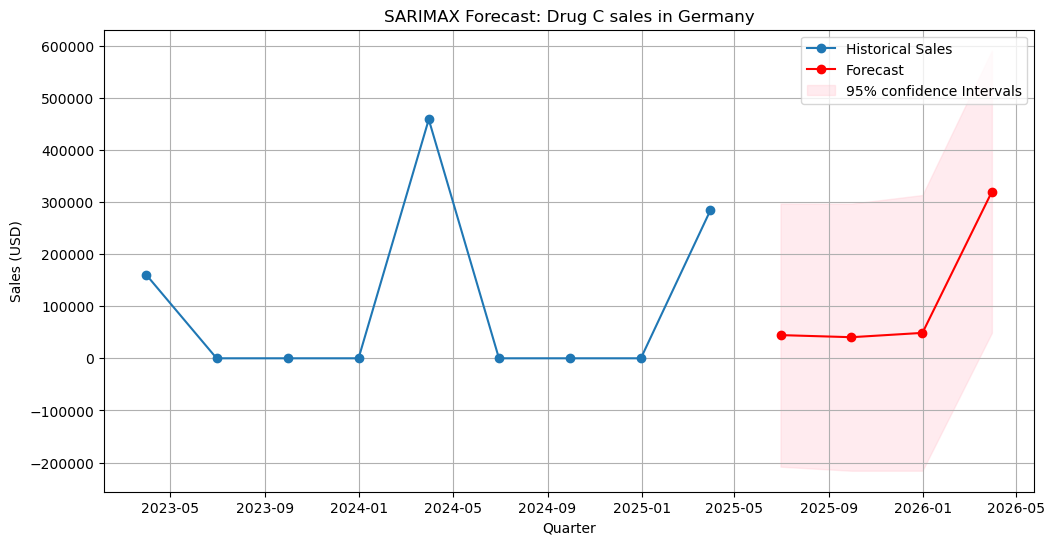

In [55]:
# Forecast next 4 quarters (1 year ahead)

forecast_steps = 4 
forecast = result.get_forecast(steps = forcast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

#Create future dates
last_date = quarterly_sales.index[-1]
future_dates = pd.date_range(start = last_date + pd.DateOffset(months=3), periods = forecast_steps, freq = 'Q')

#Plot results
plt.figure(figsize = (12,6))

#Historical data
plt.plot(quarterly_sales.index, quarterly_sales, label = 'Historical Sales', marker = 'o')

#Forecast
plt.plot(future_dates, forecast_mean, label = 'Forecast', color = 'red', marker = 'o')

#Confidence intervals
plt.fill_between(future_dates,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1],
                color = 'pink', alpha = 0.3, label = '95% confidence Intervals')
plt.title('SARIMAX Forecast: Drug C sales in Germany')
plt.xlabel('Quarter')
plt.ylabel('Sales (USD)')
plt.legend()
plt.grid(True)
plt.show()
